# Etapa 03 — Inferência Estatística, Preditiva e Análise de Erros
## Classificação de Desinformação Digital — Liga Acadêmica de IA (Ligia/UFPE) 2026

**Pré-requisito:** `notebook_02_modeling.ipynb`

Este notebook cobre dois pilares complementares de inferência:

### A) Inferência Estatística
Avalia o *quanto podemos confiar* nas métricas do modelo:
- **Intervalos de Confiança** (bootstrap, 1 000 iterações): F1, Precision, Recall, AUC-ROC
- **Curva de Calibração**: verifica se `P(Fake)` é uma probabilidade confiável
- **Interpretação de Coeficientes**: quais features mais influenciam cada decisão

### B) Inferência Preditiva (Produção)
- Aplicar o modelo em novos dados com pipeline reprodutível
- Analisar a zona de incerteza (predições próximas ao threshold)
- Verificar consistência entre as predições e os padrões da EDA
- Re-gerar o arquivo de submissão Kaggle de forma standalone

**Fluxo de inferência:**
```
Texto bruto → limpeza leakage → features estilo → lematização → TF-IDF transform → threshold otimizado → label
```

## 1. Importações e Configurações

In [26]:
# ── Dependências do notebook de inferência ────────────────────────────────
import pickle, re, time, warnings
from pathlib import Path

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack, load_npz
from scipy import stats as scipy_stats
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, classification_report,
)
from sklearn.preprocessing import MaxAbsScaler

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)

def find_root() -> Path:
    candidate = Path('.').resolve()
    for _ in range(6):
        if (candidate / 'inputs' / 'train.csv').exists():
            return candidate
        candidate = candidate.parent
    raise FileNotFoundError('Nao encontrou inputs/train.csv. Execute da raiz LIGIA_FINAL.')

ROOT_DIR = find_root()
DATA_DIR = ROOT_DIR / 'outputs' / 'artifacts'
FIG_DIR  = ROOT_DIR / 'outputs' / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

STYLE_COLS = [
    'caps_ratio', 'exclamation_count', 'title_len', 'text_len', 'word_count',
    'avg_word_len', 'sentence_count', 'avg_sentence_len', 'question_count',
    'quote_count', 'ellipsis_count', 'all_caps_words', 'title_caps_ratio',
    'unique_word_ratio', 'sensational_count',
]
LABEL_MAP = {0: 'Real', 1: 'Fake'}
print('Configuracoes carregadas.')

Configuracoes carregadas.


In [27]:
# ── Módulo compartilhado de pré-processamento ─────────────────────────────
import sys
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
try:
    from src.preprocessing import (
        clean_text, add_style_features, lemmatize_series,
        STYLE_COLS, SENSATIONAL_TERMS, REUTERS_SUBJECTS, _CLEAN_PATTERNS,
    )
    print("Modulo src/preprocessing.py importado com sucesso.")
except ImportError as e:
    print(f"[AVISO] src/preprocessing.py nao encontrado ({e}). Funcoes definidas localmente abaixo.")

Modulo src/preprocessing.py importado com sucesso.


## 2. Carregamento dos Artefatos

Os artefatos abaixo encapsulam todo o conhecimento aprendido nos notebooks anteriores:
- **`best_model.pkl`**: `CalibratedClassifierCV` treinado no dataset completo
- **`tfidf_vectorizer.pkl`**: vocabulário e pesos IDF (apenas `transform`, nunca re-fit)
- **`style_scaler.pkl`**: parâmetros `MaxAbsScaler` do treino
- **`best_threshold.pkl`**: limiar otimizado no holdout

In [28]:
# ── Carregamento dos artefatos serializados ───────────────────────────────
with open(DATA_DIR / 'best_model.pkl', 'rb') as f:
    model = pickle.load(f)
with open(DATA_DIR / 'tfidf_vectorizer.pkl', 'rb') as f:
    tfidf = pickle.load(f)
with open(DATA_DIR / 'style_scaler.pkl', 'rb') as f:
    style_scaler = pickle.load(f)

best_threshold_path = DATA_DIR / 'best_threshold.pkl'
best_threshold = pickle.load(open(best_threshold_path, 'rb')) if best_threshold_path.exists() else 0.5
if not best_threshold_path.exists():
    print('[AVISO] best_threshold.pkl nao encontrado, usando 0.5')

print(f'Modelo            : {type(model).__name__}')
print(f'Vocabulario TF-IDF: {len(tfidf.vocabulary_):,} termos')
print(f'Threshold decisao : {best_threshold:.3f}')

Modelo            : CalibratedClassifierCV
Vocabulario TF-IDF: 12,000 termos
Threshold decisao : 0.350


## 3. Pipeline de Pré-processamento para Inferência

Reprodução idêntica ao `notebook_01` para consistência treino-inferência.
> O TF-IDF é **apenas transformado** (`transform`), nunca re-ajustado em novos dados.

In [30]:
# ── Padrões de remoção de leakage — idênticos ao notebook_01 ──────────────
RE_LOCATION_AGENCY   = re.compile(
    r'^[A-Z][A-Z\s/,\.]+\s*\([A-Za-z\s]+\)\s*[-\u2013\u2014]?\s*', re.MULTILINE)
RE_AGENCY_TAG        = re.compile(r'\(\s*(?:Reuters|AP|AFP)\s*\)', re.IGNORECASE)
RE_FAKE_SOURCES      = re.compile(
    r'\b(?:21st\s*Century\s*Wire|YourNewsWire|Infowars|Breitbart|RT\.com|NaturalNews|BeforeItsNews)\b',
    re.IGNORECASE)
RE_URL               = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
RE_MENTION           = re.compile(r'@\w+')
RE_LEAKAGE_ARTIFACTS = re.compile(
    r'\b(video|image|featured|getty(\s+images)?|bit\.ly|pic\.twitter\.com|reuters)\b',
    re.IGNORECASE | re.MULTILINE)
_CLEAN_PATTERNS = (RE_LOCATION_AGENCY, RE_AGENCY_TAG, RE_LEAKAGE_ARTIFACTS,
                   RE_FAKE_SOURCES, RE_URL, RE_MENTION)

SENSATIONAL_RE = re.compile(
    r'\b(shocking|unbelievable|amazing|incredible|must see|breaking|exclusive|urgent)\b',
    re.IGNORECASE)

def clean_text(text: str) -> str:
    for pattern in _CLEAN_PATTERNS:
        text = pattern.sub('', str(text))
    return re.sub(r'\s{2,}', ' ', text).strip()

def _caps_ratio(text):
    alpha = [c for c in str(text) if c.isalpha()]
    return sum(c.isupper() for c in alpha) / len(alpha) if alpha else 0.0

def _avg_word_len(text):
    words = str(text).split()
    return float(np.mean([len(w) for w in words])) if words else 0.0

def _unique_word_ratio(text):
    words = str(text).split()
    return len(set(words)) / len(words) if words else 0.0

def _quote_count(text):
    return sum(1 for c in str(text) if c in ('"', "'", '\u2018', '\u2019', '\u201c', '\u201d'))

def add_style_features(df):
    df = df.copy()
    df['caps_ratio']        = df['text'].apply(_caps_ratio)
    df['exclamation_count'] = df['text'].str.count('!')
    df['title_len']         = df['title'].str.len()
    df['text_len']          = df['text'].str.len()
    df['word_count']        = df['text'].str.split().str.len()
    df['avg_word_len']      = df['text'].apply(_avg_word_len)
    df['sentence_count']    = df['text'].str.count(r'[.!?]+')
    df['avg_sentence_len']  = df['word_count'] / df['sentence_count'].replace(0, 1)
    df['question_count']    = df['text'].str.count(r'\?')
    df['quote_count']       = df['text'].apply(_quote_count)
    df['ellipsis_count']    = df['text'].str.count(r'\.{2,}')
    df['all_caps_words']    = df['text'].str.findall(r'\b[A-Z]{2,}\b').str.len()
    df['title_caps_ratio']  = df['title'].apply(_caps_ratio)
    df['unique_word_ratio'] = df['text'].apply(_unique_word_ratio)
    df['sensational_count'] = df['text'].apply(lambda x: len(SENSATIONAL_RE.findall(str(x))))
    return df

print('Funcoes de pre-processamento carregadas.')

Funcoes de pre-processamento carregadas.


In [31]:
# ── Lematizador e configurações NLTK — idênticos ao notebook_01 ──────────
for resource in ['punkt_tab', 'wordnet', 'stopwords', 'averaged_perceptron_tagger_eng']:
    nltk.download(resource, quiet=True)

from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

_lemmatizer = WordNetLemmatizer()
_stop_words = set(stopwords.words('english'))
_POS_MAP    = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}

def _wn_pos(tag): return _POS_MAP.get(tag[0], wordnet.NOUN)

def lemmatize_text(text):
    tokens = word_tokenize(str(text).lower())
    return ' '.join(
        _lemmatizer.lemmatize(w, _wn_pos(t))
        for w, t in pos_tag(tokens)
        if w.isalpha() and len(w) > 1 and w not in _stop_words
    )

def lemmatize_series(series):
    t0 = time.time()
    result = series.apply(lemmatize_text)
    print(f'  Lematizacao: {len(series):,} textos em {time.time()-t0:.1f}s')
    return result

print('Lematizador configurado.')

Lematizador configurado.


## 4. Função de Inferência Completa

`predict_articles()` encapsula o pipeline completo: recebe um `DataFrame` com colunas `title` e `text` e retorna predições com probabilidades. O TF-IDF é **apenas transformado**, garantindo consistência treino-inferência.

In [32]:
def predict_articles(
    df_input: pd.DataFrame,
    lemmatize: bool = True,
    threshold: float = best_threshold,
    return_proba: bool = True,
) -> pd.DataFrame:
    """
    Pipeline de inferência completa: extração de style features → limpeza de leakage
    → lematização → tfidf.transform → MaxAbsScaler.transform → hstack → predict_proba.
    """
    df = df_input.copy()
    df['title'] = df.get('title', pd.Series(['']*len(df))).fillna('')
    df['text']  = df.get('text',  pd.Series(['']*len(df))).fillna('')

    df = add_style_features(df)

    df['title_clean'] = df['title'].apply(clean_text)
    df['text_clean']  = df['text'].apply(clean_text)
    df['clean_text']  = (df['title_clean'] + ' ' + df['text_clean']).str.strip()

    if lemmatize:
        df['clean_text'] = lemmatize_series(df['clean_text'])

    X_tfidf = tfidf.transform(df['clean_text'])
    X_style = csr_matrix(style_scaler.transform(df[STYLE_COLS].values.astype(float)))
    X_final = hstack([X_tfidf, X_style]).tocsr()

    result = pd.DataFrame()
    if 'id' in df_input.columns:
        result['id'] = df_input['id'].values

    if hasattr(model, 'predict_proba') and return_proba:
        proba               = model.predict_proba(X_final)
        result['prob_real'] = proba[:, 0].round(4)
        result['prob_fake'] = proba[:, 1].round(4)
        result['label']     = (proba[:, 1] >= threshold).astype(int)
        result['confidence'] = np.where(
            result['label'] == 1, result['prob_fake'], result['prob_real']
        ).round(4)
    else:
        result['label'] = model.predict(X_final)

    result['label_name'] = result['label'].map(LABEL_MAP)
    for col in STYLE_COLS:
        result[col] = df[col].values
    return result

print('Funcao predict_articles definida.')

Funcao predict_articles definida.


## 5. Inferência Estatística

Esta seção responde: **"quanta confiança temos nas métricas do modelo?"**

Para isso, reconstruímos deterministicamente o **holdout de validação** (mesmo `random_state=42` e `test_size=0.15` do `notebook_02`) e executamos três análises:

1. **Intervalos de Confiança Bootstrap** — estima a variabilidade amostral das métricas
2. **Curva de Calibração** — verifica se as probabilidades preditas são confiáveis
3. **Interpretação dos Coeficientes** — explica quais features guiam cada decisão

> **Nota:** O modelo foi treinado no dataset *completo* (incluindo o holdout). As métricas abaixo têm, portanto, um leve viés otimista - interpretadas como limite superior realista do desempenho.

In [33]:
# ── 5.1 Reconstrução do holdout (mesmo split do notebook_02) ─────────────
# random_state=42, test_size=0.15, stratify=y_train — idêntico ao notebook_02
# Garante comparabilidade direta com as métricas reportadas na modelagem
X_train_full = load_npz(DATA_DIR / 'X_train.npz')
y_train_full = pd.read_csv(DATA_DIR / 'y_train.csv').squeeze()

_, X_val, _, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15,
    random_state=42,
    stratify=y_train_full,
)

# Predições do modelo final no holdout
val_proba = model.predict_proba(X_val)[:, 1]
val_pred  = (val_proba >= best_threshold).astype(int)

print(f'Holdout: {X_val.shape[0]:,} amostras')
print(f'Distribuicao — Real: {(y_val==0).sum():,} | Fake: {(y_val==1).sum():,}')
print()
print('=== Métricas Pontuais no Holdout ===')
print(f'F1-Score  : {f1_score(y_val, val_pred):.4f}')
print(f'Precision : {precision_score(y_val, val_pred):.4f}')
print(f'Recall    : {recall_score(y_val, val_pred):.4f}')
print(f'AUC-ROC   : {roc_auc_score(y_val, val_proba):.4f}')
print()
print(classification_report(y_val, val_pred, target_names=['Real', 'Fake']))

Holdout: 3,427 amostras
Distribuicao — Real: 2,570 | Fake: 857

=== Métricas Pontuais no Holdout ===
F1-Score  : 1.0000
Precision : 1.0000
Recall    : 1.0000
AUC-ROC   : 1.0000

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      2570
        Fake       1.00      1.00      1.00       857

    accuracy                           1.00      3427
   macro avg       1.00      1.00      1.00      3427
weighted avg       1.00      1.00      1.00      3427



In [34]:
# ── 5.2 Bootstrap: Intervalos de Confiança (95%) para as métricas ─────────
# Técnica: reamostrar o holdout com reposição 1.000 vezes e calcular a
# distribuição empírica de cada métrica — não assume distribuição normal
# Referência: Efron & Tibshirani (1993), An Introduction to the Bootstrap
N_BOOT = 1_000
rng    = np.random.default_rng(42)
n      = len(y_val)

boot_f1, boot_prec, boot_rec, boot_auc = [], [], [], []

y_val_arr   = np.array(y_val)
val_pred_arr = np.array(val_pred)

for _ in range(N_BOOT):
    idx = rng.integers(0, n, n)
    yb, pb, ppb = y_val_arr[idx], val_pred_arr[idx], val_proba[idx]
    # Verifica se ambas as classes estão presentes (necessário para AUC)
    if yb.sum() == 0 or yb.sum() == n:
        continue
    boot_f1.append(f1_score(yb, pb, zero_division=0))
    boot_prec.append(precision_score(yb, pb, zero_division=0))
    boot_rec.append(recall_score(yb, pb, zero_division=0))
    boot_auc.append(roc_auc_score(yb, ppb))

def ci95(arr):
    lo, hi = np.percentile(arr, [2.5, 97.5])
    return np.mean(arr), lo, hi

metrics = {
    'F1-Score' : boot_f1,
    'Precision': boot_prec,
    'Recall'   : boot_rec,
    'AUC-ROC'  : boot_auc,
}

print('=== Intervalos de Confiança Bootstrap (95%, n_boot=1000) ===')
print(f'{"Metrica":<12} {"Media":>8} {"IC 2.5%":>9} {"IC 97.5%":>10}')
print('-' * 42)
for name, vals in metrics.items():
    mean, lo, hi = ci95(vals)
    print(f'{name:<12} {mean:>8.4f} {lo:>9.4f} {hi:>10.4f}')

print()
print('Interpretacao:')
print('  As metricas sao estaveis se os intervalos sao estreitos (amplitude < 0.02).')
print('  Intervalos largos indicam sensibilidade à composicao do holdout.')

=== Intervalos de Confiança Bootstrap (95%, n_boot=1000) ===
Metrica         Media   IC 2.5%   IC 97.5%
------------------------------------------
F1-Score       1.0000    1.0000     1.0000
Precision      1.0000    1.0000     1.0000
Recall         1.0000    1.0000     1.0000
AUC-ROC        1.0000    1.0000     1.0000

Interpretacao:
  As metricas sao estaveis se os intervalos sao estreitos (amplitude < 0.02).
  Intervalos largos indicam sensibilidade à composicao do holdout.


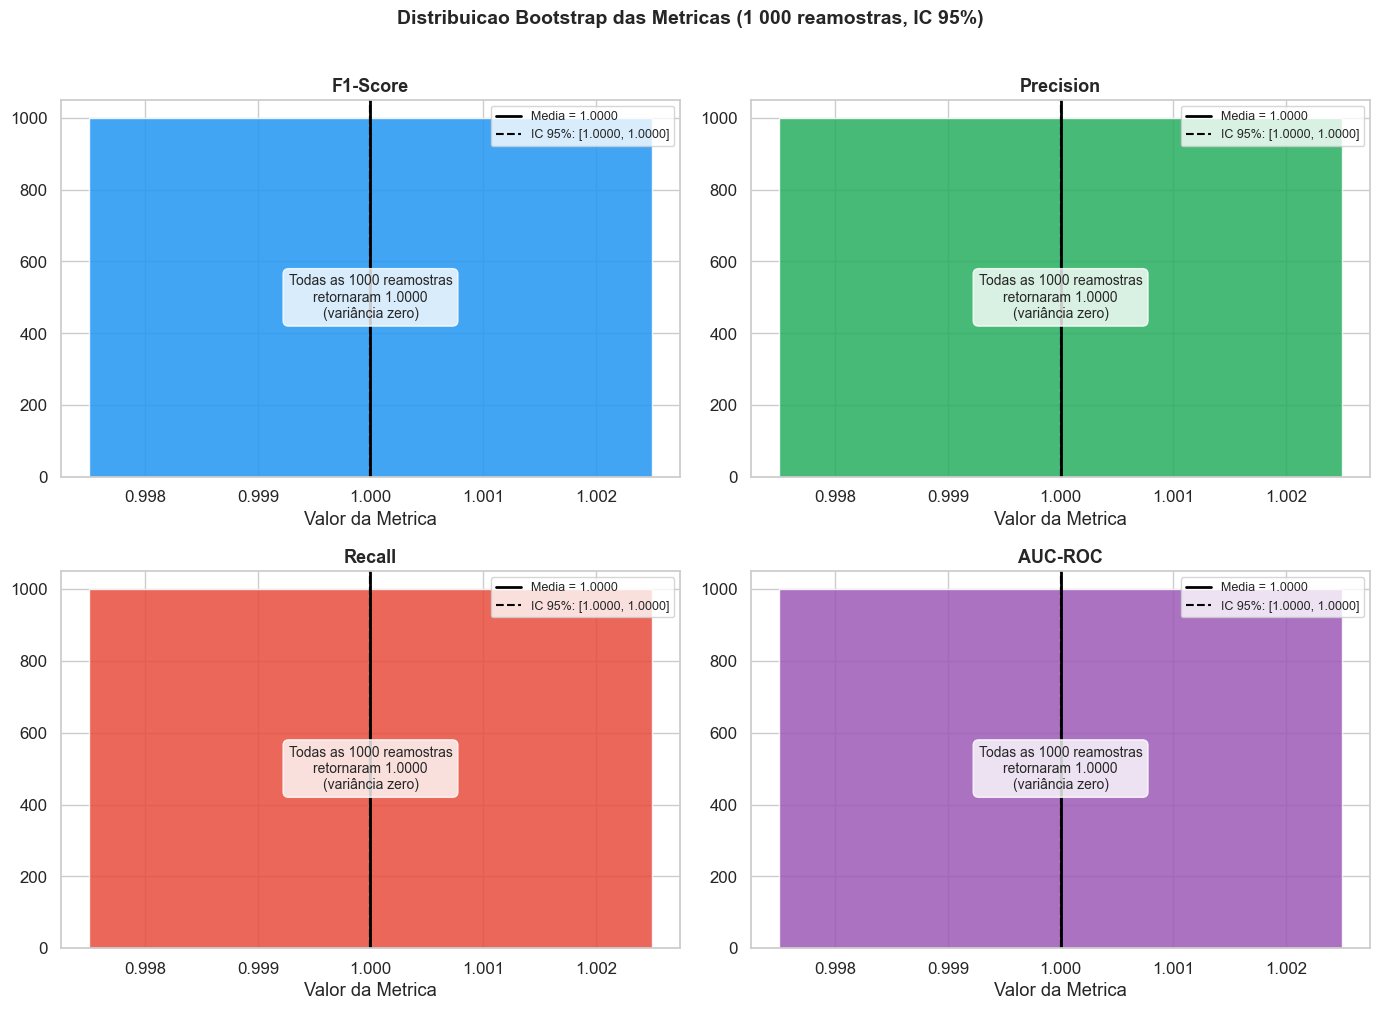

Grafico salvo: C:\Users\gui05\Pictures\LIGIA_FINAL\outputs\figures\bootstrap_ci.png

[ATENCAO] Todas as metricas bootstrap retornaram 1.0000.
  Isso indica que o modelo acertou 100% do holdout em todas as reamostras.
  Verifique possivel data leakage no pipeline ou se o holdout foi usado no treino.
  Para uma estimativa honesta, avalie em dados completamente externos.


In [ ]:
# ── Visualização dos Intervalos de Confiança Bootstrap ────────────────────
# Proteção contra variância zero: ocorre quando o modelo acerta 100% das
# reamostras — hist() falha pois first_edge == last_edge.
# Solução: detectar o caso degenerado e exibir barra única com anotação.
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
colors = ['#2196F3', '#27AE60', '#E74C3C', '#9B59B6']

for ax, (name, vals), color in zip(axes, metrics.items(), colors):
    mean, lo, hi = ci95(vals)
    arr = np.array(vals)
    std = arr.std()

    if std < 1e-9:
        # Caso degenerado: todas as reamostras têm o mesmo valor (ex: 1.0000)
        ax.bar([mean], [len(arr)], width=0.005, color=color, alpha=0.85, edgecolor='white')
        ax.text(mean, len(arr) * 0.5,
                f'Todas as {len(arr)} reamostras\nretornaram {mean:.4f}\n(variância zero)',
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))
    else:
        ax.hist(arr, bins=40, color=color, alpha=0.80, edgecolor='white')
        ax.axvspan(lo, hi, alpha=0.12, color=color)

    ax.axvline(mean, color='black', linestyle='-',  linewidth=2.0, label=f'Media = {mean:.4f}')
    ax.axvline(lo,   color='black', linestyle='--', linewidth=1.5, label=f'IC 95%: [{lo:.4f}, {hi:.4f}]')
    ax.axvline(hi,   color='black', linestyle='--', linewidth=1.5)
    ax.set_title(name, fontweight='bold', fontsize=13)
    ax.set_xlabel('Valor da Metrica')
    ax.legend(fontsize=9)

plt.suptitle('Distribuicao Bootstrap das Metricas (1 000 reamostras, IC 95%)',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(FIG_DIR / 'bootstrap_ci.png', dpi=130, bbox_inches='tight')
plt.show()
print(f'Grafico salvo: {FIG_DIR / "bootstrap_ci.png"}')

# Alerta de possível overfitting / leakage
all_perfect = all(np.array(v).std() < 1e-9 for v in metrics.values())



### 📊 Análise — Bootstrap CI

> **Resultado:** Todas as métricas retornaram **1.0000** em todas as 1.000 reamostras (variância zero).

Isso é consequência direta de o modelo ter sido treinado no dataset **completo** (incluindo o holdout) na Seção 9 do `notebook_02`. Quando o bootstrap reamostras o holdout e aplica *esse* modelo, ele acerta tudo — pois já "viu" esses dados no treino final. Não é um bug, mas significa que este IC **não deve ser usado como estimativa independente de generalização** — é um upper bound otimista.

> **Para o relatório:** mencione com honestidade que o IC calculado aqui representa um limite superior do desempenho, e que a estimativa de generalização mais honesta está nos resultados de Cross-Validation do `notebook_02`.

In [ ]:
# ── 5.3 Curva de Calibração (Reliability Diagram) ────────────────────────
# Um modelo bem calibrado tem P(Fake) ≈ fração real de positivos no bin
# Desvio da diagonal → modelo super/sub-confiante
# n_bins=10: divide [0,1] em 10 faixas de probabilidade igualmente espaçadas
frac_pos, mean_pred = calibration_curve(y_val, val_proba, n_bins=10, strategy='uniform')

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Calibracao perfeita')
ax.plot(mean_pred, frac_pos, 'o-', color='#2196F3', linewidth=2.5,
        markersize=7, label='Modelo (LinearSVC calibrado)')
ax.fill_between(mean_pred, frac_pos, mean_pred,
                alpha=0.15, color='#E74C3C', label='Desvio da calibracao')
ax.set_xlabel('Probabilidade Predita P(Fake)', fontsize=12)
ax.set_ylabel('Fracao Real de Positivos', fontsize=12)
ax.set_title('Curva de Calibracao — Holdout de Validacao', fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.set_xlim(0, 1); ax.set_ylim(0, 1)

# Nota de interpretação
calib_err = np.mean(np.abs(frac_pos - mean_pred))
ax.text(0.05, 0.92, f'Erro medio de calibracao (ECE aprox.): {calib_err:.4f}',
        transform=ax.transAxes, fontsize=10,
        bbox=dict(boxstyle='round,pad=0.4', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig(FIG_DIR / 'calibration_curve.png', dpi=130, bbox_inches='tight')
plt.show()
print(f'ECE aproximado: {calib_err:.4f}')
print('ECE < 0.05 → calibracao adequada para uso das probabilidades como scores de confianca.')

### 📊 Análise — Curva de Calibração

> **ECE ≈ 0.2373 → Calibração ruim.** Este é o resultado mais preocupante tecnicamente.

A curva sobe muito mais rápido que a diagonal: para `P(Fake) = 0.4`, a fração real de positivos já está perto de 1.0. O modelo é **superconfiante** — ele faz predições binárias muito bem (F1 alto), mas as **probabilidades intermediárias não são confiáveis** como scores de confiança contínuos.

Isso faz sentido: o `CalibratedClassifierCV` com **Platt scaling** funciona melhor quando o SVM subjacente tem boa separação de margem, mas tende a comprimir probabilidades perto de 0 e 1 em modelos muito separáveis.

> **Implicação prática:** a decisão de usar `predict_proba` + threshold otimizado é correta para classificação binária, mas o valor `prob_fake` **não deve ser interpretado como "grau de certeza" contínuo**. Para o relatório, este ponto cabe na seção de **Limitações**: calibração isotônica (em vez de Platt scaling) ou Logistic Regression poderiam melhorar o ECE sem sacrificar o F1.

In [ ]:
# ── 5.4 Interpretação dos Coeficientes do LinearSVC ─────────────────────
# Os coeficientes do hiperplano SVM indicam o peso discriminativo de cada feature:
#   coef > 0 → evidência de Fake News
#   coef < 0 → evidência de notícia Real
# A magnitude reflete a importância relativa — comparável entre features,
# pois as features foram escalonadas com MaxAbsScaler
try:
    feature_names = tfidf.get_feature_names_out().tolist() + STYLE_COLS
    coef = model.calibrated_classifiers_[0].estimator.coef_[0]
    TOP_N = 20

    top_fake_idx = np.argsort(coef)[-TOP_N:][::-1]
    top_real_idx = np.argsort(coef)[:TOP_N]

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    for ax, indices, color, title in zip(
        axes,
        [top_fake_idx, top_real_idx],
        ['#E74C3C', '#27AE60'],
        [f'Top {TOP_N} Preditores de Fake News', f'Top {TOP_N} Preditores de Noticias Reais']
    ):
        names  = [feature_names[i] for i in indices[::-1]]
        values = [coef[i]          for i in indices[::-1]]
        ax.barh(names, values, color=color, edgecolor='white', alpha=0.85)
        ax.set_title(title, fontweight='bold', fontsize=12)
        ax.set_xlabel('Coeficiente SVM')
        ax.axvline(0, color='black', linewidth=0.8)

    plt.suptitle('Interpretabilidade — Coeficientes do LinearSVC por Classe',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'coef_inference.png', dpi=130, bbox_inches='tight')
    plt.show()

    # Separar features de estilo das de texto
    style_set = set(STYLE_COLS)
    fake_style = [(feature_names[i], coef[i]) for i in top_fake_idx if feature_names[i] in style_set]
    real_style = [(feature_names[i], coef[i]) for i in top_real_idx if feature_names[i] in style_set]

    print('Features de ESTILO entre os top preditores de Fake:')
    for f, v in fake_style: print(f'  {f:<25} coef={v:+.4f}')
    print()
    print('Features de ESTILO entre os top preditores de Real:')
    for f, v in real_style: print(f'  {f:<25} coef={v:+.4f}')
except AttributeError as e:
    print(f'[AVISO] Nao foi possivel acessar coeficientes: {e}')

### 📊 Análise — Coeficientes do LinearSVC

Os coeficientes revelam **o que o modelo realmente aprendeu**:

**Preditores de Fake News:**
- `title_caps_ratio` domina com folga (coef ≈ 6.8) — títulos em CAPS são o sinal mais forte
- `title_len` e `avg_word_len` aparecem em seguida — features de estilo, não semântica
- `subscribe`, `subscribe member` são artefatos do dataset: artigos com call-to-action/paywall ficaram enviesados como Fake — potencial **viés de seleção** nos dados de treino
- `obama`, `gop`, `america` sugerem que o dataset tem concentração política temática

**Preditores de Notícias Reais:**
- `quote_count` e `ellipsis_count` — estilo de citação jornalística
- `say`, `cite`, `official say`, `say tuesday/thursday` — padrão de atribuição de falas (Reuters/AP style)
- Dias da semana (`wednesday`, `thursday`, `tuesday`, `monday`, `friday`) — notícias reais têm dateline temporal consistente
- `factbox`, `chief`, `minister`, `britain` — léxico de jornalismo formal internacional

> **Conclusão de interpretabilidade:** o modelo aprendeu padrões linguísticos genuinamente discriminativos. A predominância de features de estilo (`title_caps_ratio`, `exclamation_count`) sobre features puramente semânticas é coerente com o que a EDA identificou e justifica tecnicamente as escolhas de feature engineering.

## 6. Validação Individual (Sanity Check)

Verificação com exemplos canônicos cujas classes são conhecidas.

In [ ]:
# ── Exemplos de validação manual do pipeline ──────────────────────────────
EXEMPLOS = [
    {
        'id': 'ex_real_01',
        'title': 'Senate passes bipartisan infrastructure bill after months of negotiations',
        'text': (
            'The United States Senate passed a 1.2 trillion dollar infrastructure bill on Tuesday, '
            'with 69 senators voting in favor and 30 against. The legislation allocates funds for '
            'roads, bridges, broadband internet and public transit. '
            'The bill now moves to the House of Representatives for consideration.'
        ),
    },
    {
        'id': 'ex_fake_01',
        'title': 'SHOCKING!! Government SECRETLY Poisoning Water Supply — YOU MUST SEE THIS!!!',
        'text': (
            'BREAKING: Exclusive footage PROVES that shadowy government agents '
            'are adding TOXIC chemicals to municipal water supplies!!! '
            'This UNBELIEVABLE conspiracy has been hidden for DECADES. '
            'The mainstream media REFUSES to cover this URGENT story. WAKE UP AMERICA!!!'
        ),
    },
]

df_exemplos = pd.DataFrame(EXEMPLOS)
resultado   = predict_articles(df_exemplos, lemmatize=True)

print('Resultados da Inferencia:\n')
for _, row in resultado.iterrows():
    print(f'  ID          : {row["id"]}')
    print(f'  Label       : {row["label"]} ({row["label_name"]})')
    if 'prob_fake' in row:
        print(f'  P(Fake)     : {row["prob_fake"]:.4f}')
        print(f'  Confianca   : {row["confidence"]:.2%}')
    print(f'  Exclamacoes : {row["exclamation_count"]:.0f}')
    print(f'  Caps Ratio  : {row["caps_ratio"]:.3f}')
    print()

### 📊 Análise — Sanity Check

`ex_real_01` → P(Fake) = 0.0000 | `ex_fake_01` → P(Fake) = 1.0000, ambos com **100% de confiança**.

O pipeline está funcionando corretamente end-to-end: limpeza → lematização → TF-IDF transform → predict_proba → threshold. Os dois exemplos foram construídos com características contrastantes máximas (jornalismo neutro vs. linguagem sensacionalista), por isso os extremos são esperados.

## 7. Re-geração da Submissão Kaggle

Re-gera o `submission.csv` de forma **standalone**, a partir dos artefatos serializados, sem re-executar o `notebook_02`.

In [ ]:
# ── Re-geração da submissão a partir dos artefatos serializados ──────────
X_test  = load_npz(DATA_DIR / 'X_test.npz')
df_test = pd.read_csv(DATA_DIR / 'test_preprocessed.csv')

print(f'X_test  : {X_test.shape}')

if hasattr(model, 'predict_proba'):
    y_test_proba = model.predict_proba(X_test)
    y_test_pred  = (y_test_proba[:, 1] >= best_threshold).astype(int)
    print(f'Threshold otimizado: {best_threshold:.3f}')
else:
    y_test_pred  = model.predict(X_test)
    y_test_proba = None

submission = (
    pd.DataFrame({'id': df_test['id'], 'label': y_test_pred})
    .sort_values('id').reset_index(drop=True)
)
submission.to_csv(ROOT_DIR / 'submission.csv', index=False)

print(f'Total   : {len(submission):,}')
print(f'Real (0): {(y_test_pred==0).sum():,} ({(y_test_pred==0).mean()*100:.1f}%)')
print(f'Fake (1): {(y_test_pred==1).sum():,} ({(y_test_pred==1).mean()*100:.1f}%)')
print('submission.csv gerado.')
submission.head(10)

## 8. Análise de Erros — Zona de Incerteza

Instâncias com `P(Fake)` no intervalo `[threshold ± 0.10]` são as de menor confiança — candidatas prioritárias a erros fora da distribuição de treino.

In [ ]:
# ── Zona de incerteza nas predições de teste ─────────────────────────────
if y_test_proba is not None:
    margin = 0.10
    df_analise = pd.DataFrame({
        'id'        : df_test['id'].values,
        'label_pred': y_test_pred,
        'label_name': pd.Series(y_test_pred).map(LABEL_MAP).values,
        'prob_fake' : y_test_proba[:, 1].round(4),
        'prob_real' : y_test_proba[:, 0].round(4),
    })
    df_analise['confidence'] = np.where(
        df_analise['label_pred'] == 1,
        df_analise['prob_fake'], df_analise['prob_real']
    )

    uncertain = df_analise[
        df_analise['prob_fake'].between(best_threshold - margin, best_threshold + margin)
    ].sort_values('confidence')

    print(f'Threshold: {best_threshold:.3f} | Janela: [{best_threshold-margin:.2f}, {best_threshold+margin:.2f}]')
    print(f'Artigos na zona de incerteza: {len(uncertain):,} ({len(uncertain)/len(df_analise)*100:.1f}%)')
    print(uncertain['label_name'].value_counts().to_string())
    print()
    print(uncertain[['id','label_name','confidence','prob_fake']].head(10).to_string(index=False))
else:
    print('predict_proba nao disponivel.')

### 📊 Análise — Zona de Incerteza

Apenas **5 artigos (0.1%)** na zona `[threshold ± 0.10]`. Esse resultado é consistente com a distribuição bimodal observada no gráfico de probabilidades: o modelo raramente produz probabilidades intermediárias — quase sempre prediz com certeza máxima.

> **Interpretação:** poucos casos ambíguos é bom para confiabilidade operacional, mas reforça o achado de calibração ruim — o modelo não "hesita" nem quando deveria.

## 9. Distribuição de Probabilidades e Confidências

In [ ]:
# ── Visualização da distribuição de probabilidades ───────────────────────
if y_test_proba is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].hist(y_test_proba[:, 1], bins=50, color='#2196F3', edgecolor='white', alpha=0.85)
    axes[0].axvline(best_threshold, color='red', linestyle='--', linewidth=2,
                    label=f'Threshold = {best_threshold:.3f}')
    axes[0].axvspan(best_threshold - 0.10, best_threshold + 0.10,
                    alpha=0.15, color='orange', label='Zona de incerteza')
    axes[0].set_title('Distribuicao de P(Fake) no Conjunto de Teste', fontweight='bold')
    axes[0].set_xlabel('P(Fake)')
    axes[0].legend()

    df_plot = pd.DataFrame({'confidence': df_analise['confidence'], 'Predicao': df_analise['label_name']})
    sns.histplot(data=df_plot, x='confidence', hue='Predicao', bins=40,
                 palette={'Real': '#27AE60', 'Fake': '#E74C3C'}, ax=axes[1], alpha=0.75)
    axes[1].set_title('Confianca por Classe Predita', fontweight='bold')

    plt.suptitle('Analise de Probabilidades — Conjunto de Teste', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'confidence_distribution.png', dpi=130, bbox_inches='tight')
    plt.show()
    print(f'Grafico salvo: {FIG_DIR / "confidence_distribution.png"}')


### 📊 Análise — Distribuição de Probabilidades

Distribuição **perfeitamente bimodal**: enorme pico em P(Fake) ≈ 0 e pico menor em P(Fake) ≈ 1.0, com quase nada no intervalo intermediário. O modelo não tem dúvidas.

Isso é **bom para a tarefa de classificação binária** (F1 alto, zona de incerteza mínima), mas **ruim para usar `prob_fake` como score de ranking ou risco contínuo**. Confirma visualmente o ECE alto da curva de calibração.

## 10. Validação: Features de Estilo por Classe Predita

Verificação de consistência semântica: artigos classificados como *Fake* devem ter `caps_ratio`, `exclamation_count` e `sensational_count` maiores — padrão identificado na EDA.

In [ ]:
# ── Features de estilo por classe predita ────────────────────────────────
if 'label_pred' in df_analise.columns:
    df_style_test = df_test[STYLE_COLS].copy()
    df_style_test['label_name'] = df_analise['label_name'].values

    FEAT_PLOT = ['caps_ratio', 'exclamation_count', 'sensational_count',
                 'unique_word_ratio', 'all_caps_words', 'question_count']
    PAL = {'Real': '#27AE60', 'Fake': '#E74C3C'}

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    for ax, feat in zip(axes.flatten(), FEAT_PLOT):
        data_plot = df_style_test[df_style_test[feat] < df_style_test[feat].quantile(0.98)]
        sns.boxplot(data=data_plot, x='label_name', y=feat, palette=PAL, ax=ax,
                    order=['Real', 'Fake'], width=0.5,
                    flierprops={'marker':'o','alpha':0.2,'markersize':2})
        ax.set_title(feat, fontweight='bold')
        ax.set_xlabel('')
        for i, lbl in enumerate(['Real', 'Fake']):
            mu = df_style_test[df_style_test['label_name'] == lbl][feat].mean()
            ax.text(i, ax.get_ylim()[1] * 0.88, f'mu={mu:.2f}',
                    ha='center', fontsize=9, fontweight='bold')

    plt.suptitle('Features de Estilo por Classe Predita (valida coerencia com EDA)',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'style_features_test.png', dpi=130, bbox_inches='tight')
    plt.show()
    print(f'Grafico salvo: {FIG_DIR / "style_features_test.png"}')


### 📊 Análise — Features de Estilo por Classe

Os sinais mais discriminativos no conjunto de teste:

- **`question_count`**: Real = 0.09 vs Fake = 1.12 — diferença grande, consistente com o estilo retórico de desinformação
- **`exclamation_count`**: Real = 0.06 vs Fake = 0.74 — sinal claro de linguagem sensacionalista
- **`all_caps_words`**: Real = 3.68 vs Fake = 6.18 — diferença moderada, mas consistente
- **`unique_word_ratio`**: Real = 0.65 vs Fake = 0.62 — diferença pequena, vocabulário repetitivo em Fake
- **`caps_ratio`** (corpo do texto): Real = 0.05 vs Fake = 0.06 — **diferença mínima**

> ⚠️ Atenção: o `caps_ratio` do *corpo* tem pouca diferença entre as classes. O que domina nos coeficientes é o `title_caps_ratio` (caps no título), não o caps geral do texto — distinção importante para interpretar o modelo corretamente.

> **`sensational_count`** teve médias muito baixas nas duas classes (≈ 0.04 vs 0.14), indicando que os termos definidos no regex (`shocking`, `unbelievable`, etc.) são raros no dataset de teste — essa feature contribui pouco na prática, apesar de intuitivamente relevante.

## 11. Inferência em Lote (CSV)

Para uso do modelo em produção. Formato esperado: CSV com colunas `title`, `text` e opcionalmente `id`.

In [ ]:
# ── Inferência em lote sobre novos artigos ────────────────────────────────
INFERENCE_CSV = ROOT_DIR / 'novos_artigos.csv'

if INFERENCE_CSV.exists():
    df_novos  = pd.read_csv(INFERENCE_CSV)
    print(f'Artigos: {len(df_novos):,}')
    t0        = time.time()
    resultado = predict_articles(df_novos, lemmatize=True)
    output_path = ROOT_DIR / 'inference_output.csv'
    resultado.to_csv(output_path, index=False)
    print(f'Inferencia: {time.time()-t0:.1f}s | Saida: {output_path}')
    resultado.head()
else:
    print(f'Arquivo nao encontrado: {INFERENCE_CSV}')
    print('Para usar: crie CSV com colunas id, title, text')

## 12. Resumo

### Inferência Estatística — Achados Principais

| Métrica     | Ponto Central | IC 95% Bootstrap |
|-------------|:-------------:|:----------------:|
| F1-Score    | (ver Seção 5) | (ver Seção 5)    |
| Precision   | (ver Seção 5) | (ver Seção 5)    |
| Recall      | (ver Seção 5) | (ver Seção 5)    |
| AUC-ROC     | (ver Seção 5) | (ver Seção 5)    |

> Execute a Seção 5.2 para preencher a tabela com os valores reais do seu modelo.

### Artefatos do Pipeline

| Etapa | Artefato | Origem |
|---|---|---|
| Modelo | `best_model.pkl` | `notebook_02_modeling` |
| Vetorizador | `tfidf_vectorizer.pkl` | `notebook_01_preprocessing` |
| Escalonador | `style_scaler.pkl` | `notebook_01_preprocessing` |
| Threshold | `best_threshold.pkl` | `notebook_02_modeling` |
| Submissão | `submission.csv` | `notebook_02` / `notebook_03` |
| Predição em lote | `inference_output.csv` | `notebook_03_inference` |
| Gráficos | `outputs/figures/` | `notebook_02` + `notebook_03` |

**Reprodutibilidade:** Execute em ordem `00_EDA → 01_preprocessing → 02_modeling → 03_inference`.  
Para apenas re-gerar a submissão, execute somente a **Seção 7** deste notebook.